In [1]:
from dueling_dqn.experience_replay.sorted_dict import ValueSortedDict
from dueling_dqn.experience_replay.per import RankBasedReplayBuffer, ProportionalReplayBuffer
from dueling_dqn.experience_replay.sum_tree import SumTree
import torch
import numpy as np
import gymnasium as gym

In [2]:
a = ValueSortedDict()

In [3]:
for i in range(10):
    a[i] = np.random.normal()

In [2]:
env = gym.make('CartPole-v1')
tree = ProportionalReplayBuffer(observation_space=env.observation_space, capacity=10)

In [3]:
for i in range(10):
    state = np.zeros(env.observation_space.shape)
    trans = (state, i, np.random.normal(), state, np.random.choice([0, 1]))
    err = np.random.normal()
    tree.add(trans, err)

In [209]:
idxs = np.random.choice(np.arange(10), size=(9), replace=False)
errs = np.random.normal(size=(9))
tree.update(idxs, errs)
tree.tree.tree[9:]

array([0.59076601, 0.39080721, 0.81235401, 0.33660822, 0.87118279,
       0.71528557, 0.86957957, 0.15560415, 0.52204394, 0.92873016])

In [212]:
from collections import Counter

results = []
for _ in range(100000):
    results.extend(tree.sample(7)[-1].numpy())

In [213]:
Counter(results)

Counter({np.int64(9): 104832,
         np.int64(4): 98592,
         np.int64(6): 98510,
         np.int64(2): 91901,
         np.int64(5): 80842,
         np.int64(0): 66588,
         np.int64(8): 59002,
         np.int64(1): 44432,
         np.int64(3): 37725,
         np.int64(7): 17576})

In [217]:
import dill 

with open('lcs/results_CartPole-v1_basic.pl', 'rb') as file:
    basic_array = dill.load(file)
    
with open('lcs/results_CartPole-v1_rank.pl', 'rb') as file:
    rank_array = dill.load(file)
    
with open('lcs/results_CartPole-v1_prop.pl', 'rb') as file:
    prop_array = dill.load(file)

Text(0.5, 0, 'Timestep')

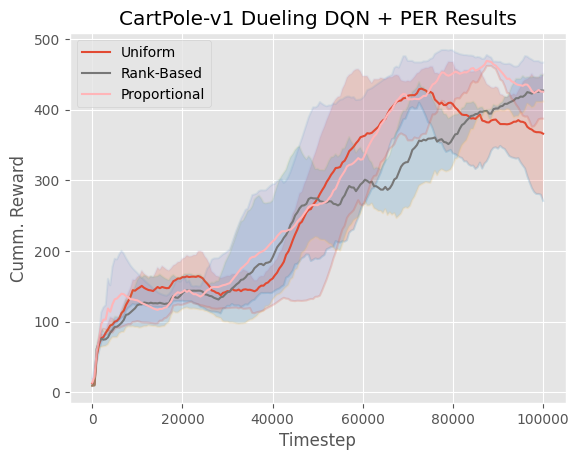

In [218]:
import matplotlib.pyplot as plt

vars_low = []
vars_high = []
q=10

for i in range(basic_array.shape[1]):
    vars_low.append(np.percentile(basic_array[:, i], q=q))
    vars_high.append(np.percentile(basic_array[:, i], q=100-q))

mean_scores = np.mean(basic_array, axis=0) 


plt.style.use('ggplot')   

xs = np.arange(0, 100000+500, 500)
plt.plot(xs, mean_scores, label='Uniform')
plt.plot(xs, vars_low, alpha=0.2)
plt.plot(xs, vars_high, alpha=0.1)
plt.fill_between(xs, vars_low, vars_high, alpha=0.2)

vars_low = []
vars_high = []
q=10

for i in range(rank_array.shape[1]):
    vars_low.append(np.percentile(rank_array[:, i], q=q))
    vars_high.append(np.percentile(rank_array[:, i], q=100-q))

mean_scores = np.mean(rank_array, axis=0) 
plt.plot(xs, mean_scores, label='Rank-Based')
plt.plot(xs, vars_low, alpha=0.2)
plt.plot(xs, vars_high, alpha=0.1)
plt.fill_between(xs, vars_low, vars_high, alpha=0.2)

vars_low = []
vars_high = []
q=10

for i in range(prop_array.shape[1]):
    vars_low.append(np.percentile(prop_array[:, i], q=q))
    vars_high.append(np.percentile(prop_array[:, i], q=100-q))

mean_scores = np.mean(prop_array, axis=0) 
plt.plot(xs, mean_scores, label='Proportional')
plt.plot(xs, vars_low, alpha=0.2)
plt.plot(xs, vars_high, alpha=0.1)
plt.fill_between(xs, vars_low, vars_high, alpha=0.2)

plt.legend()
plt.grid(True)
plt.title(f'CartPole-v1 Dueling DQN + PER Results')
plt.ylabel('Cumm. Reward')
plt.xlabel('Timestep')

In [235]:
import torch
import numpy as np

from typing import Self, Tuple
from torch import Tensor
# reused replay buffer from my ddpg implementation
class ReplayBuffer:
    def __init__(
        self: Self, 
        state_dim: int,  
        buffer_len: int, 
        device: str = 'cpu'
    ) -> None:
        
        self.capacity = buffer_len
        self.device = device
        self.pointer = 0
        self.size = 0

        self.states = torch.zeros((self.capacity, state_dim) ,dtype=torch.float,device=self.device)
        self.actions = torch.zeros((self.capacity, 1) ,dtype=torch.int64,device=self.device)
        self.rewards = torch.zeros((self.capacity, 1) ,dtype=torch.float,device=self.device)
        self.next_states = torch.zeros((self.capacity, state_dim) ,dtype=torch.float,device=self.device)
        self.dones = torch.zeros((self.capacity, 1) ,dtype=torch.int64,device=self.device)

    def add(
        self: Self, 
        state: np.ndarray, 
        action: np.ndarray, 
        reward: float, 
        next_state: np.ndarray, 
        done: float | bool
    ) -> None:

        self.states[self.pointer] = torch.as_tensor(state).to(self.device)
        self.actions[self.pointer] = torch.as_tensor(action).to(self.device) 
        self.rewards[self.pointer] = reward
        self.next_states[self.pointer] = torch.as_tensor(next_state).to(self.device)
        self.dones[self.pointer] = done

        self.pointer = (self.pointer + 1) % self.capacity 
        self.size = min(self.size + 1, self.capacity)

    def sample(self: Self, batch_size: int) -> Tuple[Tensor]:
        ind = torch.randint(0, self.size, device=self.device, size=(batch_size,))
        return (
            self.states[ind], 
            self.actions[ind], 
            self.rewards[ind], 
            self.next_states[ind], 
            self.dones[ind]
        )
        
    def __len__(self: Self) -> int:
        return len(self.states)

In [ ]:
import gymnasium as gym
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F

from copy import deepcopy
from torch import Tensor
from typing import Self, List, Tuple

from dueling_dqn.experience_replay.per import RankBasedReplayBuffer, ProportionalReplayBuffer, BasicBuffer

class FeatureExtractorAtari(nn.Module):
    
    def __init__(
        self: Self, 
        in_channels: int = 16,
        hidden_filters: List = list([32, 64, 64]),
        out_dim: int = 64, 
        *args, 
        **kwargs
    ) -> None:
        super(FeatureExtractorAtari, self).__init__(*args, **kwargs)
        
        assert len(hidden_filters) == 3, 'Feature extractor only implements 3 hidden conv layers'
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[1], hidden_filters[2], kernel_size=3, stride=1),
            nn.Flatten(start_dim=1),
            nn.Linear(hidden_filters[2] * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
        
    def forward(self, x) -> Tensor:
        x = x / 255.0
        return self.layers(x)


class DuelingArch(nn.Module):
    
    def __init__(
        self: Self, 
        env: gym.Env, 
        hidden_layers_extractor: List = list([128, 512]), 
        out_dim: int = 64, 
        start_epsilon: float = 1,
        max_decay: float = 0.1,
        decay_steps: int = 1000,
        atari: bool = False,
        device: str = 'cpu',
        *args, 
        **kwargs
    ) -> None:
        super(DuelingArch, self).__init__(*args, **kwargs)

        self.env = env
        self.num_actions = env.action_space.n
        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.device = device
        
        if atari: 
            self.initial_extractor = FeatureExtractorAtari(out_dim=out_dim, *args, *kwargs)
        else:
            self.initial_extractor = nn.Sequential(
                nn.Linear(np.prod(self.env.observation_space.shape), 
                                               out_dim), 
                nn.ReLU()
            )

            hidden_layers_extractor.insert(0, out_dim)
            for i in range(1, len(hidden_layers_extractor)):
                self.initial_extractor.append(nn.Linear(hidden_layers_extractor[i-1], hidden_layers_extractor[i])) 
                self.initial_extractor.append(nn.ReLU()) 
        
        self.value_stream = nn.Linear(hidden_layers_extractor[-1], 1)
        self.advantage_stream = nn.Linear(hidden_layers_extractor[-1], self.num_actions)
    
    def forward(self: Self, obs: Tensor) -> Tensor:
        representation = self.initial_extractor(obs)
        values = self.value_stream(representation)
        advantages = self.advantage_stream(representation)
        
        return values + (advantages - advantages.mean(dim=-1, keepdim=True))
    
    def epsilon_greedy(self: Self, obs: np.ndarray, dim: int = -1) -> Tensor:
        rng = np.random.random()
        with torch.no_grad():
            obs = torch.as_tensor(obs, dtype=torch.float32, device=self.device)
            if rng < self.epsilon:
                action = self.env.action_space.sample()
                action = torch.as_tensor(action)
            else:
                q_values = self(obs)
                action = torch.argmax(q_values, dim=dim)
            return action.detach().item()

    def epsilon_decay(self: Self, step: int) -> None:
        self.epsilon = self.max_decay + (self.start_epsilon
                                         - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)    
    
 
class DuelingNetwork:
    
    def __init__(
        self: Self, 
        env: gym.Env, 
        atari: bool = False, 
        lr: float = 6.25e-5,
        buffer_type: 'str' = 'rank', 
        buffer_size: int = int(1e6),
        gamma: float = 0.99,
        tau: float = 0.005, 
        device: str = 'cpu', 
        max_norm: float = 10, 
        stop_anneal: int = 1000, 
        *args, 
        **kwargs
    ) -> None:
        self.device = device 
        
        self.net = DuelingArch(env=env, atari=atari, device=device, **kwargs).to(device=self.device)
        self.target_net = deepcopy(self.net)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        
        # freeze the target model 
        for param in self.target_net.parameters():
            param.requires_grad = False
        
        match buffer_type:
            case 'rank': 
                self.buffer = RankBasedReplayBuffer(
                    capacity=buffer_size, observation_space=env.observation_space, device=self.device, 
                    stop_anneal=stop_anneal
                )
            case 'prop':
                self.buffer = ProportionalReplayBuffer(
                    capacity=buffer_size, observation_space=env.observation_space, device=self.device,
                    stop_anneal=stop_anneal
                )   
            case 'basic':
                self.buffer = BasicBuffer(
                    capacity=buffer_size, observation_space=env.observation_space, device=self.device,
                    stop_anneal=stop_anneal
                )   

        self.buffer_type = buffer_type
        self.val_env = deepcopy(env)
        self.gamma = gamma
        self.tau = tau
        self.max_norm = max_norm
        self.atari = atari
        
    def loss_func(self: Self, preds: Tensor, true: Tensor, weights: Tensor) -> Tensor:
        return torch.mean((true - preds).pow(2) * weights) 
    
    def epsilon_greedy(self: Self, obs: np.ndarray) -> np.ndarray: 
        return self.net.epsilon_greedy(obs)
    
    def decay(self: Self, step: int) -> None:
        self.buffer.anneal_beta(step)
        self.net.epsilon_decay(step)
    
    def update(
        self: Self, 
        batch: Tuple
    ) -> Tuple:
        states, actions, rewards, next_states, dones = batch
        
        # construct target values
        with torch.no_grad():
            online_actions = self.net(next_states).max(dim=-1, keepdim=True)[1]
            print(online_actions.shape)
            bootstrapped_values = self.target_net(next_states).gather(dim=-1, index=online_actions.detach())

            td_targets = rewards + self.gamma * bootstrapped_values * (1 - dones)
        
        q_values = self.net(states).gather(dim=-1, index=actions)    
        if self.buffer_type == 'rank' or self.buffer_type == 'prop': 
            # loss = self.loss_func(q_values, td_targets.detach(), weights.view(*weights.shape, 1))
            pass
        else: 
            loss = F.mse_loss(q_values, td_targets.detach())
        
        self.optimizer.zero_grad()
        loss.backward()
        
        # scale the gradients 
        for param in self.net.initial_extractor[-1].parameters():
            param.grad *= 1/np.sqrt(2)
                
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=self.max_norm)
        self.optimizer.step()
        
        return (td_targets - q_values).detach(), idxs, loss.item()
    
    def get_error(self: Self, transition: Tuple) -> float:
        obs, action, reward, next_obs, done = transition 
        with torch.no_grad():
            q_values = self.net(torch.as_tensor(obs, dtype=torch.float32, device=self.device).view(1, *obs.shape)).squeeze()[action]
            q_values_next = self.target_net(torch.as_tensor(next_obs, dtype=torch.float32, device=self.device).view(1, *obs.shape)).amax()
        return (reward + self.gamma * q_values_next * (1-done) - q_values).detach().cpu().numpy()
    
    def soft_update(self: Self) -> None:       
        with torch.no_grad():
            for param, target_param in zip(self.net.parameters(), self.target_net.parameters()):
                target_param.data.copy_((1-self.tau) * target_param.data + self.tau * param.data)
        
    def hard_update(self: Self) -> None:
        self.target_net.load_state_dict(self.net.state_dict())
        
    def evaluate(self: Self, num_evals: int = 10) -> float:
        self.net.eval()
        with torch.no_grad():
            rewards = []
            for _ in range(num_evals):
                obs, _ = self.val_env.reset()
                done = False
                ep_reward = 0
                while not done:
                    action = self.net(torch.as_tensor(obs, dtype=torch.float32, device=self.device).view(1, *obs.shape))
                    obs, reward, terminated, truncated, _ = self.val_env.step(action.cpu().argmax().item())
                    ep_reward += reward
                    done = terminated or truncated
                
                rewards.append(ep_reward)
        self.net.train()
        return np.mean(rewards)
    
    def save(
        self: Self,
        game_name: str
    ) -> None:
        torch.save({
            'state_dict' : self.net.state_dict(),
        }, f'models/Dueling_{game_name}.pt')
        
    def load(
        self, 
        path: str
    ) -> None:
        saved_model = torch.load(path, weights_only=True)
        self.net.load_state_dict(saved_model['state_dict'])
   
    def __repr__(self):
        return f'Dueling Agent'

In [267]:
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt

from tqdm import tqdm
from gymnasium.wrappers.atari_preprocessing import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation

from dueling_dqn.utils.metrics import RollingAverage

def train(
    env: gym.Env, 
    agent: DuelingNetwork,  
    timesteps: int = 1000000, 
    val_freq: int = 5000, 
    batch_size: int = 1024, 
    preload: int = 1000, 
    window: int = 35, 
    num_val_runs: int = 15,
    seed: int = 0
) -> RollingAverage: 
    
    metrics = RollingAverage(window)
    rb = ReplayBuffer(np.prod(env.observation_space.shape), buffer_len=int(1e4))
    obs, _ = env.reset(seed=seed)
    done = False
    
    for _ in tqdm(range(preload)):
        action = env.action_space.sample()
        obs_prime, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated
        rb.add(obs, action, reward, obs_prime, done)
        
        obs = obs_prime
        if done: 
            obs, _ = env.reset(seed=seed)
            done = False
    
    obs, _ = env.reset(seed=seed)
    done = False
    
    print('\n')
    for step in range(1, timesteps+1):
        action = agent.epsilon_greedy(obs)
        obs_prime, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated
        
        rb.add(obs, action, reward, obs_prime, done)
        
        obs = obs_prime
        if done:
            obs, _ = env.reset(seed=seed)
            done = False

        # sample and update
        if len(rb) >= batch_size:
            batch = rb.sample(batch_size)
            td_errors, idxs, loss = agent.update(batch)
            agent.decay(step)
            agent.soft_update()

        
        if step % val_freq == 0 or step == 1:
            val_reward = agent.evaluate(num_val_runs)
            metrics.update(val_reward)
            print(f'Timestep: {step} | Average Val Reward: {metrics.get_average:.4f} | Loss: {loss:.4f} | Epsilon: {agent.net.epsilon:.4f} | Beta: {agent.buffer.beta:.4f}', end='\r')
        
    env.close()
    agent.val_env.close()
    return metrics
    
def plot_results(
    scores: np.ndarray, 
    timesteps: int, 
    val_freq: int, 
    game_name: str, 
    buffer_type: str, 
    save: bool = False
) -> None:
    vars_low = []
    vars_high = []
    q=10

    for i in range(scores.shape[1]):
        vars_low.append(np.percentile(scores[:, i], q=q))
        vars_high.append(np.percentile(scores[:, i], q=100-q))

    mean_scores = np.mean(scores, axis=0) 
    plt.style.use('ggplot')   
    
    color = 'r'
    xs = np.arange(0, timesteps+val_freq, val_freq)
    plt.plot(xs, mean_scores, label='Average Val Score', color=color)
    plt.plot(xs, vars_low, alpha=0.1, color=color)
    plt.plot(xs, vars_high, alpha=0.1, color=color)
    plt.fill_between(xs, vars_low, vars_high, alpha=0.2, color=color)
    plt.legend()
    plt.grid(True)
    plt.title(f'{game_name} Dueling DQN + PER Results ({buffer_type.capitalize()})')
    plt.ylabel('Cumm. Reward')
    plt.xlabel('Timestep')
    if save:
        plt.savefig(f'lcs/dueling_dqn_{game_name}_{buffer_type}')
        
def make_env(game_name: str, atari: bool) -> gym.Env:
    env = gym.make(game_name)
    if atari: 
        env = AtariPreprocessing(env)
        env = FrameStackObservation(env, stack_size=4)
    return env 

In [268]:
agent.net

DuelingArch(
  (initial_extractor): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU()
  )
  (value_stream): Linear(in_features=512, out_features=1, bias=True)
  (advantage_stream): Linear(in_features=512, out_features=2, bias=True)
)

In [273]:
list(agent.net.parameters())[-1]

Parameter containing:
tensor([0.0257, 0.0020], requires_grad=True)

In [271]:
for param in agent.net.parameters():
    print(param.shape)

torch.Size([64, 4])
torch.Size([64])
torch.Size([128, 64])
torch.Size([128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([1, 512])
torch.Size([1])
torch.Size([2, 512])
torch.Size([2])


In [272]:
import random
env = make_env('CartPole-v0', False)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
env.action_space.seed(0)

agent = DuelingNetwork(
    env, lr=5e-4, buffer_type='basic', atari=False, 
    decay_steps=10000, stop_anneal=10000,
    buffer_size=1
)

try:
    metrics = train(
        env, agent, int(5e4), 250, 64,
        2000, seed=0
    )
except KeyboardInterrupt:
    env.close()
    agent.val_env.close()

100%|██████████| 2000/2000 [00:00<00:00, 12039.68it/s]
